In [1]:
# user defined functions
import odor_statistics_lib as osm

# dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import signal
from scipy import stats

#classification
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

#plots
import string
import figurefirst
from figurefirst import FigureLayout,mpl_functions
import matplotlib.ticker as mtick
import pylab as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None

In [40]:
dir = '~/DataAnalysis/data/Sprints/HighRes/'
fdf_windy = pd.read_hdf(dir+'Windy/WindyStatsLog.h5')
fdf_notwindy = pd.read_hdf(dir+'NotWindy/NotWindyStats.h5')
fdf_forest = pd.read_hdf(dir+'Forest/ForestStats.h5')

# windy = pd.read_hdf(dir+'Windy/WindyMASigned.h5')
# nwindy = pd.read_hdf(dir+'NotWindy/NotWindyMASigned.h5')
# forest = pd.read_hdf(dir+'Forest/ForestMASigned.h5')

In [ ]:
# create_class_column(fdf_notwindy)
# create_class_column(fdf_windy)
# create_class_column(fdf_forest)
# fdf_notwindy.to_hdf(dir+'NotWindy/NotWindyStats.h5', key='df', mode='w')
# fdf_windy.to_hdf(dir+'Windy/WindyStats.h5', key='df', mode='w')
# fdf_forest.to_hdf(dir+'Forest/ForestStats.h5', key='df', mode='w')

In [77]:
scorelh = pd.read_hdf(dir+'AccuracyScoresNB/LoggedScores/Scoreslwsh.h5')
scorehl = pd.read_hdf(dir+'AccuracyScoresNB/LoggedScores/Scoreshwsl.h5')
scorenw = pd.read_hdf(dir+'AccuracyScoresNB/LoggedScores/Scores_desert_nwindy.h5')
scorew = pd.read_hdf(dir+'AccuracyScoresNB/LoggedScores/Scores_desert_windy.h5')
scoref = pd.read_hdf(dir+'AccuracyScoresNB/LoggedScores/Scores_desert_forest.h5')
scoreft = pd.read_hdf(dir+'AccuracyScoresNB/LoggedScores/Scores_desert_forestTest1.h5')

In [78]:
def get_ticks():
    for tick in ax.xaxis.get_major_ticks():
        tick.tick1line.set_visible(True)

    for tick in ax.yaxis.get_major_ticks():
        tick.tick1line.set_visible(True)

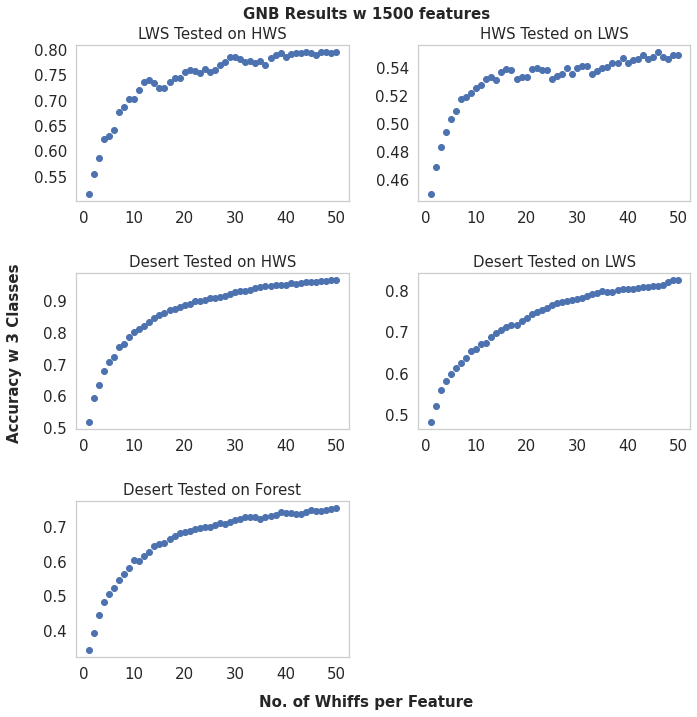

In [80]:
nrows=3
ncols=2
f , (ax) = plt.subplots(nrows,ncols, figsize = (10,10))
f.text(0.5, 0.008, 'No. of Whiffs per Feature', ha='center', fontweight='bold')
f.text(0.001, 0.5, 'Accuracy w 3 Classes', va='center', rotation='vertical',fontweight='bold')
ax[0][0].scatter(scorelh.encounters, scorelh.accuracy)
ax[0][0].set_title('LWS Tested on HWS')

ax[0][1].scatter(scorehl.encounters, scorehl.accuracy)
ax[0][1].set_title('HWS Tested on LWS')

ax[1][0].scatter(scorew.encounters, scorew.accuracy)
ax[1][0].set_title('Desert Tested on HWS') 

ax[1][1].scatter(scorenw.encounters, scorenw.accuracy)
ax[1][1].set_title('Desert Tested on LWS') 

ax[2][0].scatter(scoref.encounters, scoref.accuracy)
ax[2][0].set_title('Desert Tested on Forest') 

# ax[2][1].scatter(scoreft.encounters, scoreft.accuracy)
# ax[2][1].set_title('Desert Tested on Forest') 


f.delaxes(ax[2,1]) ## Deleted the unwanted row
for i in range(nrows):
    for j in range (ncols):
        ax[i][j].grid(False)
f.tight_layout(pad=3)
f.suptitle('GNB Results w 1500 features',fontweight='bold')
figurefirst.mpl_functions.set_fontsize(f, 15)
# f.savefig('../../Figure/GNBResultsLogged.jpeg', dpi=300, bbox_inches = "tight")

In [6]:
def get_statistics(df,index,fdf):
    osm.avg_distance(df,index,fdf)
    osm.mean_conc(df,index,fdf)
    osm.motion_statistics(df,index,fdf)
    osm.whiff_blank_duration(df,index,fdf)
    osm.trajectory_speed(df,index,fdf)
    osm.encounter_frequency(df,index,fdf,1,2)
    osm.mean_avg(df,index,fdf)
    osm.mean_conc(df,index,fdf)

In [7]:
np.seterr(divide = 'ignore') 
indexW = osm.get_index(windy)
indexNW = osm.get_index(nwindy)
fdf_windy = pd.DataFrame()
fdf_notwindy = pd.DataFrame()
fdf_forest = pd.DataFrame()
get_statistics(windy,indexW,fdf_windy)
get_statistics(nwindy,indexNW,fdf_notwindy)
indexF = osm.get_index_forest(forest)
get_statistics(forest,indexF,fdf_forest)

In [9]:
fdf_windy['type']=np.zeros(len(fdf_windy))
fdf_notwindy['type']=np.zeros(len(fdf_notwindy))
fdf_forest['type']=np.zeros(len(fdf_forest))

In [66]:
# fdf_forest.to_hdf(dir+'Forest/ForestStats.h5', key='fdf_forest', mode='w')

In [34]:
print(np.power(10,0.7)) # 5meters
# print(np.power(10,1.31))
print(np.power(10,1.5))
print(np.power(10,1.7))

5.011872336272722
31.622776601683793
50.11872336272722


# Classify

In [6]:
def create_class_column_forest(dataframe):
    dataframe.loc[dataframe.avg_dist_from_source < 5, 'type'] = 0
    dataframe.loc[(dataframe.avg_dist_from_source >= 5)  & (dataframe.avg_dist_from_source < 10), 'type'] = 1
    dataframe.loc[dataframe.avg_dist_from_source >= 10, 'type'] = 2
    return dataframe

In [7]:
def create_class_column(dataframe):
    dataframe.loc[dataframe.avg_dist_from_source < 5, 'type'] = 0
    dataframe.loc[(dataframe.avg_dist_from_source >= 5)  & (dataframe.avg_dist_from_source < 30), 'type'] = 1
    dataframe.loc[dataframe.avg_dist_from_source >= 30, 'type'] = 2
    return dataframe

In [8]:
def create_class_column_log(dataframe):
    dataframe.loc[dataframe.log_avg_dist_from_source_signed < 0.7, 'type'] = 0
    dataframe.loc[(dataframe.log_avg_dist_from_source_signed >= 0.7)  & 
                  (dataframe.log_avg_dist_from_source_signed < 1.5), 'type'] = 1
    dataframe.loc[dataframe.log_avg_dist_from_source_signed >= 1.5, 'type'] = 2
    return dataframe

In [9]:
def get_rows(dataframe, N):
    nrows = dataframe.sample(1)
    Nrows = dataframe[(nrows.index).values[0]:(nrows.index+N).values[0]]
    return Nrows

In [74]:
# for each collection of data to use for the classifier, get statistics from N encounters
def get_N_consecutive_encounter_stats(dataframe, distance_class, N):
    df_q = dataframe.query('type == ' + str(distance_class))   
    df_q.reset_index(inplace=True, drop=True)     
    Nrows = get_rows(df_q,N)
    return np.ravel( Nrows[['mean_concentration','mean_ef','log_whiff','mean_ma']].values )

In [75]:
# for each collection of data to use for the classifier, get statistics from N encounters
def get_N_random_encounter_stats(dataframe, distance_class, N):
    df_q = dataframe.query('type == ' + str(distance_class))   
    df_q.reset_index(inplace=True, drop=True)     
    Nrows = df_q.sample(N)
    return np.ravel( Nrows[['mean_concentration','mean_ef','log_whiff','mean_ma']].values )

In [ ]:
def stack_arrays(a):
    A = np.full((len(a), max(map(len, a))), np.nan)
    for i, aa in enumerate(a):
        A[i, :len(aa)] = aa
    return A


In [73]:
def gather_stat_random(dataframe, distance_class, number_of_encounters,X,y):
    for i in range(2000):
        X.append(get_N_random_encounter_stats(dataframe, distance_class, number_of_encounters))
        y.append(distance_class)
    return X,y

def gather_stat_consecutive(dataframe, distance_class, number_of_encounters,X,y):
    for i in range(2000):
        X.append(get_N_consecutive_encounter_stats(dataframe, distance_class, number_of_encounters))
        y.append(distance_class)
    return X,y

In [13]:
newtest  = pd.concat([fdf_notwindy, fdf_windy])
newtest.reset_index(inplace=True, drop=True) 

In [97]:
    Xtest = []
    ytest = []
    Xtrain = []
    ytrain = []


In [103]:
# cl = [0,1,2]
number_of_encounters = 15

## Trainset
trainset= fdf_notwindy
Xtrain = []
ytrain = []

## TestSet
testset = fdf_windy
Xtest = []
ytest = []

for distance_class in [0,1,2]:
    Xtrain,ytrain = gather_stat_consecutive(trainset,distance_class,number_of_encounters, Xtrain,ytrain) 
Xtrain = stack_arrays(Xtrain)
# # Xtrain = np.vstack(Xtrain)


# for distance_class in [0,1,2]:
#     Xtest,ytest = gather_stat_consecutive(testset,distance_class,number_of_encounters, Xtest,ytest)    
# Xtest = stack_arrays(Xtest)
# Xtest = np.vstack(Xtest)

In [39]:
## TRAINED WITH NOT WINDY AND TESTED on WINDY
clf = GaussianNB()
y_pred = clf.fit(Xtrain,ytrain).predict_proba(Xtest)
print("Naive Bayes Test set Score: ",clf.score(Xtest, ytest))

# # print("Naive Bayes Train set Score: ",clf.score(Xtrain, ytrain))
# print("Number of mislabeled points out of a total %d points : %d"
#       % (Xtest.shape[0], (ytest != y_pred).sum()))

Naive Bayes Test set Score:  0.7833333333333333


In [62]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(ytest, y_pred))
print(metrics.classification_report(ytest, y_pred))

Accuracy: 0.6948333333333333
              precision    recall  f1-score   support

           0       0.63      0.97      0.76      2000
           1       0.78      0.14      0.23      2000
           2       0.76      0.98      0.86      2000

    accuracy                           0.69      6000
   macro avg       0.72      0.69      0.62      6000
weighted avg       0.72      0.69      0.62      6000



In [104]:
# Train classifier
X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain, test_size=0.5, random_state=0)
gnb = GaussianNB()

# test classifier
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

print("Naive Bayes score: ",gnb.score(X_test, y_test))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## Gradient Descent

In [ ]:
predict_proba(X)

In [ ]:
# def gradient_descent(gradient, start, learn_rate, n_iter=50, tolerance=1e-06):
#     vector = start
   
#     for _ in range(n_iter):
#         diff = -learn_rate * gradient(vector)
#         if np.all(np.abs(diff) <= tolerance):
#             break
#         vector += diff
#         a.append(vector)
#     return vector


# a = []
# vector = gradient_descent(
#     gradient=lambda v: 4 * v**3 - 10 * v - 3, start=0,
#     learn_rate=0.1
# )


# def f(x):
# #     return np.sin(x) + x + x * np.sin(x)
#     return 4 * np.power(x,3) - 10*x -3\


# x = np.linspace(-3, 3, 50)
# plt.plot(x,f(x))
# plt.plot(a,'o')
# plt.xlim(-3,3)

## Model theoretical whiff frequency as a gamma distribution with a scale factor that increases with distance

In [26]:
np.shape(Xtrain)

(6000, 60)

In [ ]:
def whiff_freq_from_distance(distance, N):
    scale = 1 + 4*np.log(distance+1)
    G = scipy.stats.gamma(2, 0, scale)
    raw_whiff_frequencies = G.rvs(N)
    return raw_whiff_frequencies

distance = np.logspace(-1, 3)

whiff_freqs = []
distances = []
for d in distance:
    N = 100
    wfs = whiff_freq_from_distance(d, N)
    whiff_freqs.extend( wfs.tolist() )
    distances.extend(N*[d])
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot( np.array(distances), np.array(whiff_freqs), '.', alpha=0.3)
ax.set_xscale('log')
ax.set_xlim(1e-1, 1e2)

# With increasing distance, concentration falls, whiffs harder to detect, so frequency should fall

Model concentration effect as a normal distribution with a mean that falls according to an exponential distribution

In [ ]:
def concentration_effect_from_distance(distance, N):
    mean = scipy.stats.expon(0,40).pdf(d) / 0.025
    concentration_effects = scipy.stats.norm(mean, 0.3).rvs(N)
    concentration_effects[concentration_effects<0] = 0
    return concentration_effects

distance = np.logspace(-1, 3)

conc_effects = []
distances = []
for d in distance:
    N = 100
    ces = concentration_effect_from_distance(d, N)
    conc_effects.extend( ces.tolist() )
    distances.extend(N*[d])
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot( np.array(distances), np.array(conc_effects), '.', alpha=0.3)
ax.set_xscale('log')
ax.set_xlim(1e-1, 1e2)

# Model observed whiff frequency as a product of the two

In [ ]:
whiff_freqs = []
distances = []
concentrations = []
for d in distance:
    N = 100
    
    raw_whiff_frequencies = whiff_freq_from_distance(d, N)
    concentration_effects = concentration_effect_from_distance(d, N)
    
    wfs = raw_whiff_frequencies*concentration_effects
    wfs = wfs / 10
    
    whiff_freqs.extend( wfs.tolist() )
    distances.extend(N*[d])
    concentrations.extend(concentration_effects)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot( np.array(distances), np.array(whiff_freqs), '.', alpha=0.3)

ax.set_xscale('log')
ax.set_xlim(1e-1, 1e2)
ax.set_ylim(0, 8)

In [ ]:
df = pd.DataFrame({'distance': distances, 
                       'whiff_freq': whiff_freqs, 
                       'concentration': concentrations,
                       'type': [0]*len(whiff_freqs)})